In [ ]:
#pip install -U ydata-profiling

In [46]:
import pandas as pd
#from ydata_profiling import ProfileReport
import re
import json
import csv

# 1. Read in Data

In [8]:
file_path = "/content/ZYXW_tripfiles.csv"

In [ ]:
# Beispieldaten
#data = pd.read_csv(file_path, delimiter=';', quotechar='"', engine='python')

In [41]:
# Daten
data = pd.read_csv(file_path, delimiter=',', quotechar='"', engine='python', on_bad_lines='skip')

In [42]:
data

,id,creation_time,airline_code,flight_number,flight_date,departure_airport,user_name,action_name,header_line,entry_details
0,375119858,2024-04-30 04:22:41,ZY,6075,30,BVB,service-acco,AutomaticNotificationAction,"2024-04-30 04:22:41,144 INFO [3fc43b0d2af9531...",NaN
1,375119859,2024-04-30 04:22:41,ZY,6075,30,BVB,service-acco,AutomaticNotificationAction,"2024-04-30 04:22:41,146 INFO [3fc43b0d2af9531...",STATUS AIRCRAFT_CONFIG 1 EZFW 1 CARGO_FINAL 1 ...
2,375120627,2024-04-30 05:02:44,ZY,119,30,NAT,service-acco,AutomaticNotificationAction,"2024-04-30 05:02:44,524 INFO [f479b5e3ee955eb...",NaN
3,375120699,2024-04-30 04:17:43,ZY,5027,30,SSA,service-acco,AutoLoadBulkAction,"2024-04-30 04:17:43,876 INFO [a2561ff07178a19...",NULL\nLoaded pre-autoload state:\nPOSITIONS\nn...
4,375120700,2024-04-30 04:17:43,ZY,5027,30,SSA,service-acco,AssignLoadplanAction,"2024-04-30 04:17:43,877 INFO [a2561ff07178a19...",com.systemone.lc2.loadplan.dto.PositionAssignm...
...,...,...,...,...,...,...,...,...,...,...
29556,375159695,2024-05-01 00:30:26,ZY,9706,29,VCP,service-acco,ASMMsgProcessor,"2024-05-01 00:30:26,534 INFO [8279b80bd7bce39...",The message was processed successfully
29557,375159696,2024-05-01 00:30:32,ZY,9707,30,MCO,service-acco,ASMMsgProcessor,"2024-05-01 00:30:32,789 INFO [6cc68a25d296685...","<?xml version=""1.0"" encoding=""UTF-8""?><ns2:OSS..."
29558,375159715,2024-05-01 00:30:26,ZY,5154,29,ARU,service-acco,ASMMsgProcessor,"2024-05-01 00:30:26,548 INFO [4e125233520b7e5...",The message was processed successfully
29559,375159716,2024-05-01 00:30:29,ZY,5307,30,MCZ,service-acco,ASMMsgProcessor,"2024-05-01 00:30:29,473 INFO [5a483b9aa8e3c44...","<?xml version=""1.0"" encoding=""UTF-8""?><ns2:OSS..."


# 2. Understanding the Data

In [ ]:
profile = ProfileReport(data, title="Profiling Report - Lufthansa")

In [ ]:
profile

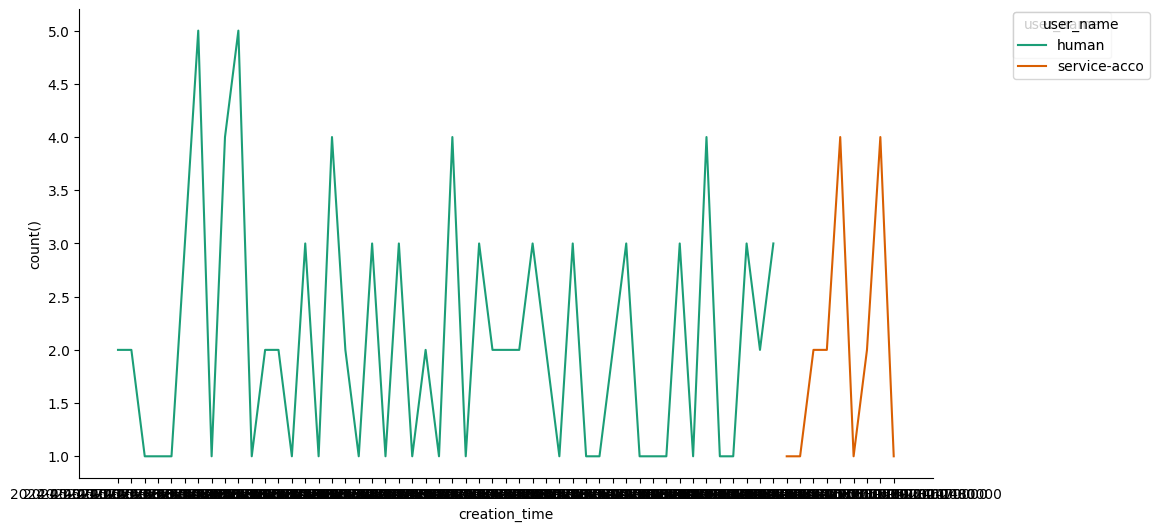

In [ ]:
# @title creation_time vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['creation_time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'creation_time'}, axis=1)
              .sort_values('creation_time', ascending=True))
  xs = counted['creation_time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('creation_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('user_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='user_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('creation_time')
_ = plt.ylabel('count()')

In [ ]:
data["action_name"].unique()

array(['CalculateWeightAndTrimAction', 'EstimateStorePaxDataAction',
       'StorePaxDataAction', 'AutoLoadBulkAction', 'AssignLoadplanAction',
       'UpdateFlightAction', 'AssignLCCAction',
       'GetCabinConfigurationsAction',
       'StoreRegistrationAndConfigurationAc', 'UpdateCrewDataAction',
       'TransferCargoAction', 'AssignUnassignViewAction',
       'AutomaticNotificationAction', 'CreateZFWMessageAction',
       'CreateBaggageLoadItemsAction', 'UpdateLoadTableAction',
       'UpdateFuelDataAction', 'CreateLoadingInstructionAction',
       'CargoFinalAction', 'RampFinalAction', 'CreateLoadsheetAction'],
      dtype=object)

# 2. Process the Data

In [ ]:
# List of all keys, including weights, indices, and specific aircraft parameters
weight_keys = [
    "START_WI weight",
    "START_WI index",
    "DO_WI weight",
    "DO_WI index",
    "PAX_WI weight",
    "PAX_WI index",
    "TOTAL_DEADLOAD_WI weight",
    "TOTAL_DEADLOAD_WI index",
    "TOTAL_LOAD_WI",
    "TOTAL_TRAFFIC_LOAD",
    "FUEL_INDEX",
    "AZFW",
    "ATOW",
    "ALAW",
    "FUEL_INDEX",
    "AFT_LIMIT_ZFW",
    "Start Weight",
    "Start Index",
    "Total Weight",
    "Index",
    "ATXW",
    "FWD_LIMIT_ZFW"
]

# Create the regex pattern dynamically from the list of keys
pattern = rf'({"|".join(map(re.escape, weight_keys))})\s*:\s*([0-9.]+)'

# Define a function to extract the relevant details
def extract_weight_details(data_string):
    extracted_data = re.findall(pattern, data_string)
    return {key.strip(): float(value) for key, value in extracted_data}

# Apply the function to the 'entry_details' column
data['extracted_data'] = data['entry_details'].astype(str).apply(extract_weight_details)

# Convert extracted dictionary into separate columns
for key in weight_keys:
    data[key] = data['extracted_data'].apply(lambda x: x.get(key, None))

In [ ]:
data.to_csv("_tripfile_extracted_weights.csv")